![Logo 1](https://git.wmi.amu.edu.pl/AITech/Szablon/raw/branch/master/Logotyp_AITech1.jpg)
<div class="alert alert-block alert-info">
<h1> Komputerowe wspomaganie tłumaczenia </h1>
<h2> 4,5. <i>Klasyfikacja tematyczna (terminologii ciąg dalszy)</i> [laboratoria]</h2> 
<h3>Rafał Jaworski (2021)</h3>
</div>

![Logo 2](https://git.wmi.amu.edu.pl/AITech/Szablon/raw/branch/master/Logotyp_AITech2.jpg)

# Komputerowe wspomaganie tłumaczenia

# Zajęcia 4 i 5 - klasyfikacja tematyczna (terminologii ciąg dalszy)

Na poprzednich zajęciach opracowaliśmy nasz własny ekstraktor terminologii. Mówiliśmy również, jak ważna jest ekstrakcja terminów specjalistycznych. Dziś zajmiemy się zagadnieniem, w jaki sposób wyciągnąć z tekstu terminy, które naprawdę są specjalistyczne.

Dlaczego nasze dotychczasowe rozwiązanie mogło nie spełniać tego warunku? Wykonajmy następujące ćwiczenie:

### Ćwiczenie 1: Zgromadź korpus w języku angielskim składający się z co najmniej 100 dokumentów, z których każdy zawiera co najmniej 100 zdań. Wykorzystaj stronę https://opus.nlpl.eu/. Dobrze, aby dokumenty pochodziły z różnych dziedzin (np. prawo Unii Europejskiej, manuale programistyczne, medycyna). Ściągnięty korpus zapisz na swoim dysku lokalnym, nie załączaj go do niniejszego notatnika.

Taki korpus pozwoli nam zaobserwować, co się stanie, jeśli do ekstrakcji terminologii będziemy stosowali wyłącznie kryterium częstościowe. Aby wykonać odpowiedni eksperyment musimy uruchomić ekstraktor z poprzednich zajęć.

import nltk
nltk.download('punkt')  # Pobierz tokenizator zdania, jeśli jeszcze go nie masz

def podziel_na_zdania(nazwa_pliku):
    with open(nazwa_pliku, 'r') as plik:
        tekst = plik.read()
        zdania = nltk.sent_tokenize(tekst)
        return zdania

nazwa_pliku = 'tekst.txt'  # Zmień na nazwę swojego pliku
zdania = podziel_na_zdania(nazwa_pliku)

for zdanie in zdania:
    print(zdanie)### Ćwiczenie 2: Uruchom ekstraktor terminologii (wykrywacz rzeczowników) z poprzednich zajęć na każdym dokumencie z osobna. Jako wynik ekstraktora w każdym przypadku wypisz 5 najczęściej występujących rzeczowników. Wyniki działania komendy umieść w notatniku.

In [17]:
from collections import Counter
import spacy
import pprint

def extract_terms(path,returnTop5=True):
    f = open(path)
    text = f.read()
    f.close()
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    nouns = [token.lemma_ for token in doc if token.pos_ == "NOUN"]
    nouns_counts = Counter(nouns)
    if returnTop5:
        top_5 = nouns_counts.most_common(5)
        answer = {word: count for word, count in top_5}
    else:
        answer = nouns_counts
        
    
    return answer

In [2]:
books = extract_terms("./books/Books.en-pl.en")
pprint.pprint(books)

{'day': 84, 'man': 215, 'moor': 148, 'night': 89, 'time': 89}


In [3]:
food = extract_terms("./food/ELRC-479-Polish_Food_2.en-pl.en")
pprint.pprint(food)

{'food': 189, 'fruit': 174, 'product': 325, 'production': 154, 'quality': 146}


In [7]:
employment = extract_terms("./emplo/ELRC-888-Employment_Services_.en-pl.en")
pprint.pprint(employment)

{'benefit': 272, 'employer': 270, 'eures': 305, 'period': 229, 'person': 328}


```python
books = {'day': 84, 'man': 215, 'moor': 148, 'night': 89, 'time': 89}
food = {'food': 189, 'fruit': 174, 'product': 325, 'production': 154, 'quality': 146}
employment  = {'benefit': 272, 'employer': 270, 'eures': 305, 'period': 229, 'person': 328}
```

Czy wyniki uzyskane w ten sposób to zawsze terminy specjalistyczne? Niestety może zdarzyć się, że w wynikach pojawią się rzeczowniki, które są po prostu częste w języku, a niekoniecznie charakterystyczne dla przetwarzanych przez nas tekstów. Aby wyniki ekstrakcji były lepsze, konieczne jest zastosowanie bardziej wyrafinowanych metod.

Jedną z tych metod jest znana z dyscypliny Information Retrieval technika zwana TF-IDF. Jej nazwa wywodzi się od **T**erm **F**requency **I**nverted **D**ocument **F**requency. Według tej metody, dla każdego odnalezionego przez nas termu powinniśmy obliczyć czynnik TF-IDF, a następnie wyniki posortować malejąco po wartości tego czynnika.

Jak obliczyć czynnik TF-IDF? Czym jest TF, a czym jest IDF?

Zacznijmy od TF, bo ten czynnik już znamy. Jest to nic innego jak częstość wystąpienia terminu w tekście, który przetwarzamy. Idea TF-IDF skupia się na drugim czynniku - IDF. Słowo *inverted* oznacza, że czynnik ten będzie odwrócony, czyli trafi do mianownika. W związku z tym TF-IDF to w istocie:
$\frac{TF}{DF}$

Czym zatem jest document frequency? Jest to liczba dokumentów, w których wystąpił dany termin. Dokumenty w tym przypadku są rozumiane jako jednostki, na które podzielony jest korpus, nad którym pracujemy (dokładnie taki, jak korpus z ćwiczenia pierwszego).

Zastanówmy się nad sensem tego czynnika. Pamiętajmy, że naszym zadaniem jest ekstracja terminów z tylko jednego dokumentu na raz. Mamy jednak do dyspozycji wiele innych dokumentów, zawierających wiele innych słów i termów. Wartość TF-IDF jest tym większa, im częściej termin występuje w dokumencie, na którym dokonujemy ekstrakcji. Czynnik ten jednak zmniejsza się, jeśli słowo występuje w wielu różnych dokumentach. Zatem, popularne słowa będą miały wysoki czynnik DF i niski TF-IDF. Natomiast najwyższą wartość TF-IDF będą miały terminy, które są częste w przetwarzanym przez nas dokumencie, ale nie występują nigdzie indziej.

### Ćwiczenie 3: Zaimplementuj czynnik TF-IDF i dokonaj ekstrakcji terminologii za jego pomocą, używając korpusu z ćwiczenia nr 1. Czy wyniki różnią się od tych uzyskanych tylko za pomocą TF?

In [56]:
books = extract_terms("./books/Books.en-pl.en",False)
food = extract_terms("./food/ELRC-479-Polish_Food_2.en-pl.en",False)
employment = extract_terms("./emplo/ELRC-888-Employment_Services_.en-pl.en",False)

In [95]:
def get_idf(SETS):
    idf = {}
    for SET in SETS:
        for word,count in SET.items():
            idf[word] = idf.get(word, 0) + 1
    return idf

def tfidf_extract(SET):
    idf = get_idf([books,food,employment])
    for word,count in SET.items():
        if word in idf:
            SET[word] = count/idf.get(word)
    most = SET.most_common(5)
    return most

pprint.pprint(tfidf_extract(books))

[('moor', 148.0),
 ('hound', 62.0),
 ('sir', 61.0),
 ('baronet', 48.0),
 ('window', 45.0)]


In [96]:
pprint.pprint(tfidf_extract(food))

[('product', 325.0),
 ('apple', 127.0),
 ('vegetable', 99.0),
 ('honey', 92.0),
 ('cheese', 71.0)]


In [97]:
pprint.pprint(tfidf_extract(employment))

[('eures', 305.0),
 ('worker', 228.0),
 ('insurance', 150.0),
 ('benefit', 136.0),
 ('employer', 135.0)]


```python
books = {'day': 84, 'man': 215, 'moor': 148, 'night': 89, 'time': 89}
vs = [('moor', 148.0),('hound', 62.0),('sir', 61.0),('baronet', 48.0),('window', 45.0)]

food = {'food': 189, 'fruit': 174, 'product': 325, 'production': 154, 'quality': 146}
vs = [('product', 325.0),('apple', 127.0),('vegetable', 99.0),('honey', 92.0),('cheese', 71.0)]

employment  = {'benefit': 272, 'employer': 270, 'eures': 305, 'period': 229, 'person': 328}
vs =  [('eures', 305.0),('worker', 228.0),('insurance', 150.0),('benefit', 136.0),('employer', 135.0)]
```

Teraz potrafimy już w lepszy sposób wyciągać terminy z dokumentów. Spróbujmy jeszcze czegoś widowiskowego - wygenerujmy tzw. chmurę słów z tekstu przy użyciu biblioteki WordCloud dla artykułu z BBC News (https://www.bbc.com/news/world-europe-56530714):

sudo pip install wordcloud

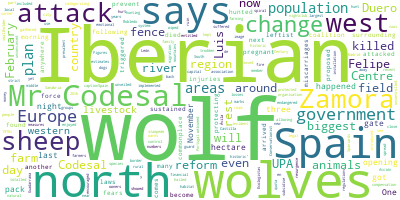

In [1]:
from wordcloud import WordCloud

text = """"This is where it happened," says Felipe Luis Codesal, opening the gate to a three-hectare field on his farm in Zamora, north-west Spain.

One night last November, a pack of wolves got through the fence surrounding the field and attacked Mr Codesal's sheep, many of which were pregnant. When he arrived the next morning, he found 11 animals had been killed. Over the following days, he says, another 36 sheep died from injuries sustained in that attack and miscarriages it triggered.

Mr Codesal fears that such attacks will become even more commonplace if a proposed change to laws protecting the Iberian wolf comes into force.

The leftist coalition government plans to prevent the Iberian wolf from being hunted anywhere by categorising it as an endangered species. The reform is yet to be implemented and could see changes.

Iberian wolves from the Iberian Wolf Centre in Robledo de Sanabria on February 21, 2020 in Zamora, Spain
image captionSpain has Europe's biggest wolf population: These Iberian wolves are kept at Zamora's Iberian wolf centre
"It's like in a nightclub when there's a fire," says Mr Codesal of the wolf attack. "There's a stampede and people get trodden on and hurt. This is the same."

He was not entitled to any compensation and estimates that the financial losses he suffered from this incident totalled around €12-14,000

"It's not even about the money," he says. "It's emotional, because the animals are part of my family."

A 'historic' change?
The region of Castilla y León is the habitat for most of Spain's wolves. Figures gathered by the local government showed that they killed 3,774 sheep and cows in the region in 2019.

Felipe Luis Codesal's farm is just north of the Duero river, which marks a natural border between north-west Spain and the rest of the country. Until now, it has been legal to hunt wolves north of the Duero, under a strict quota system, because that is where they are most prevalent.

South of the river they have been protected.

Conservationist groups have welcomed the government plan. When it was unveiled in February, the Ecologistas en Acción organisation hailed it as a "historic day".

But Mr Codesal, who is a member of the UPA association of smallholder farmers, warns the reform will ruin livestock owners by allowing the wolf population to spiral out of control and roam uncontrolled. The UPA is unconvinced by measures included in the plan to subsidise the installation of fences and the use of guard dogs in livestock farming areas.

Biggest wolf numbers in Europe
The Iberian wolf was close to being wiped out in the middle of the 20th Century. But it enjoyed a resurgence on the back of new hunting regulations introduced in the 1970s and the migration of Spaniards away from rural areas also encouraged its spread down from the north-western corner of the country.

In recent years, wolves have moved into areas such as the Guadarrama mountains north of Madrid and near the city of Ávila, to the west of the capital.

There are now some 2,500 Iberian wolves: around 2,000 are in Spain - the largest wolf population in western Europe - and the rest in Portugal.
"""

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(text)
wordcloud.to_image()

### Ćwiczenie 4: Wykonaj chmurę słów dla całego korpusu z ćwiczenia nr 1.

In [19]:
from wordcloud import WordCloud
from collections import Counter
import spacy
def my_word_cloud(path):
    
    f = open(path,'r', encoding='utf-8')
    text = f.read()
    f.close()
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    tally = {}
    nouns = [token.lemma_ for token in doc if token.pos_ == "NOUN"]
    nouns_counts = Counter(nouns)
      
    top_4000 = nouns_counts.most_common(4000)
    
    tally = {word: count for word, count in top_4000}
    
    wordcloud = WordCloud(background_color="white", max_words=4000, contour_width=3, contour_color='steelblue')
    wordcloud.generate_from_frequencies(tally)
    return wordcloud

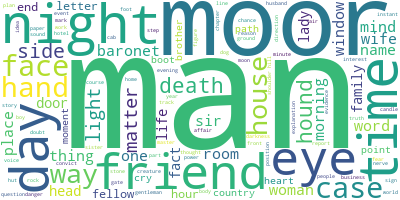

In [18]:
img = my_word_cloud("./books/Books.en-pl.en")
img.to_image()   

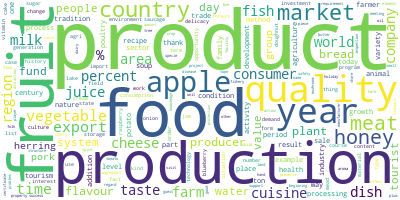

In [21]:
img = my_word_cloud("./food/ELRC-479-Polish_Food_2.en-pl.en")
img.to_image()

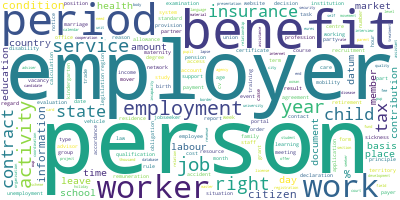

In [22]:
img = my_word_cloud("./emplo/ELRC-888-Employment_Services_.en-pl.en")
img.to_image()

Zastanówmy się nad jeszcze jednym zagadnieniem - jak pogrupować te terminy ze względu na dziedzinę? Zagadnienie to nosi nazwę klasyfikacji tematycznej. A dzięki pewnemu XIX-wiecznemu niemieckiemu matematykowi możliwe jest przeprowadzenie tego procesu automatycznie. Matematyk ten nosił nazwisko Peter Gustav Lejeune Dirichlet, a metoda klasyfikacji nazywa się LDA (**L**atent **D**irichlet **A**llocation).

### Ćwiczenie 5: Wykonaj tutorial dostępny pod https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0. Wklej do notatnika wyniki.